# Introduction

In today's competitive hospitality industry, understanding and improving guest satisfaction is critical for hosts, property managers, and platform administrators to maintain high occupancy rates and positive reviews.

Airbnb, as one of the leading platforms in the short-term rental market, provides a wealth of data through guest reviews.Will use Natural Language Processing (NLP) and machine learning to extract actionable insights from review data.

The primary objective of this project is to develop a sentiment analysis pipeline capable of measuring guest satisfaction over time by analyzing sentiment from Airbnb reviews. This system will enable hosts and property managers to track changes in guest satisfaction, evaluate the effectiveness of improvements or changes made to their properties or services, and make data-driven decisions to enhance guest experiences.

This solution will enable hosts to better understand their guests' experiences and provide actionable insights that lead to improved guest satisfaction, higher occupancy rates, and increased bookings



# The Data


# Preprocessing

Importing data

In [ ]:
import pandas as pd

In [ ]:
# Data loading
df = pd.read_csv('reviews.csv')

In [ ]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...


Data Inspection

In [ ]:
# Check the shape of data
print(df.shape)

(503626, 6)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503626 entries, 0 to 503625
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     503626 non-null  int64 
 1   id             503626 non-null  int64 
 2   date           503626 non-null  object
 3   reviewer_id    503626 non-null  int64 
 4   reviewer_name  503625 non-null  object
 5   comments       503528 non-null  object
dtypes: int64(3), object(3)
memory usage: 23.1+ MB
None


In [ ]:
# Check for missing values
print(df.isnull().sum())

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     1
comments         98
dtype: int64


Handling Missing Values

In [ ]:
# Drop rows with missing values
df.dropna(subset=['comments'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

Cleaning the Review Text

In [ ]:
#Remove unnecessary characters, HTML tags, URLs, and special symbols.
#Convert all text to lowercase for consistency.
import re

def clean_text(text):
    # Remove HTML tags as they might confuse the model.
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs as they might not provide valuable sentiment information
    text = re.sub(r'http\S+|www.\S+', '', text)

    return text

# Apply cleaning function to the review text column
df['cleaned_comments'] = df['comments'].apply(clean_text)

# Display cleaned reviews
print(df[['comments', 'cleaned_comments']].head())

                                            comments  \
0  Great home away from home! Bridgette and Marth...   
1  Das Cottage liegt ruhig und sicher.  Wir haben...   
2  This cottage was a great base from which to ex...   
3  I had a great stay.  All my needs were well ex...   
4  Excellent host. She provided everything we cou...   

                                    cleaned_comments  
0  Great home away from home! Bridgette and Marth...  
1  Das Cottage liegt ruhig und sicher.  Wir haben...  
2  This cottage was a great base from which to ex...  
3  I had a great stay.  All my needs were well ex...  
4  Excellent host. She provided everything we cou...  


Detect and Remove Non-English Reviews

In [ ]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility in language detection: Ensuring Consistent Results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        # If language detection fails, assume it's not English
        return 'unknown'

In [ ]:
#Apply Language Detection

# Add a new column for detected language
df['language'] = df['cleaned_comments'].apply(detect_language)

# Display the language distribution
print(df['language'].value_counts())

language
en         457197
de          19279
fr           7606
nl           3388
ro           2118
pt           2086
unknown      1436
af           1319
es           1258
it            906
ca            796
ar            735
so            542
tl            536
ru            495
no            488
sv            450
cs            320
sw            264
hr            260
da            236
zh-cn         234
hu            201
ko            185
cy            178
id            149
he            142
fi            139
pl            112
tr             87
vi             73
et             70
ja             62
sl             43
sk             41
zh-tw          22
fa             19
ur             17
sq             10
uk              9
bg              7
lt              5
th              2
hi              2
el              2
lv              2
Name: count, dtype: int64


Filter Out Non-English Reviews

In [ ]:
# Filter out non-English reviews
df_english = df[df['language'] == 'en']

# Reset index after filtering
df_english.reset_index(drop=True, inplace=True)

# Check the shape of the filtered dataset
print("Original dataset size:", df.shape)
print("Filtered dataset size:", df_english.shape)

Original dataset size: (503528, 8)
Filtered dataset size: (457197, 8)


Save the filtered dataset for model training

In [ ]:
# Save the filtered dataset to a CSV file
df_english.to_csv('airbnb_reviews_english.csv', index=False)

# RoBERTa Model

In [30]:
# Import neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [31]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [32]:
# import cleaned data
reviews_df = pd.read_csv('airbnb_reviews_english.csv')

In [33]:
# Imput Airbnb listing ID
listing_id = 3191

# Filter the DataFrame for the specified listing_id
filtered_reviews = reviews_df[reviews_df['listing_id'] == listing_id]
print(filtered_reviews['listing_id'].value_counts())

listing_id
3191    67
Name: count, dtype: int64


In [36]:
example = filtered_reviews['cleaned_comments'][5]
print(example)

Fantastic cottage! Fantastic host. Safe neighbourhood, friendly cats, and two fat, sleepy rabbits! Thanks so much for your hospitality!


In [37]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.001588672, 'roberta_neu': 0.0064450908, 'roberta_pos': 0.99196625}


In [38]:
from tqdm import tqdm

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [39]:
results = {}
for i, row in tqdm(filtered_reviews.iterrows(), total=len(filtered_reviews)):
  try:
    text = row['cleaned_comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    results[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

100%|██████████| 67/67 [00:30<00:00,  2.22it/s]


In [41]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = filtered_reviews.merge(results_df, how='left')

In [42]:
results_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,cleaned_comments,language,roberta_neg,roberta_neu,roberta_pos
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...,Great home away from home! Bridgette and Marth...,en,0.001197,0.008272,0.990532
1,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...,This cottage was a great base from which to ex...,en,0.000973,0.011327,0.987700
2,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...,I had a great stay. All my needs were well ex...,en,0.001322,0.008167,0.990511
3,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...,Excellent host. She provided everything we cou...,en,0.001646,0.009582,0.988771
4,3191,34203620,2015-06-06,30266918,Thomas,This was the perfect guest home for me to stay...,This was the perfect guest home for me to stay...,en,0.001068,0.012378,0.986554


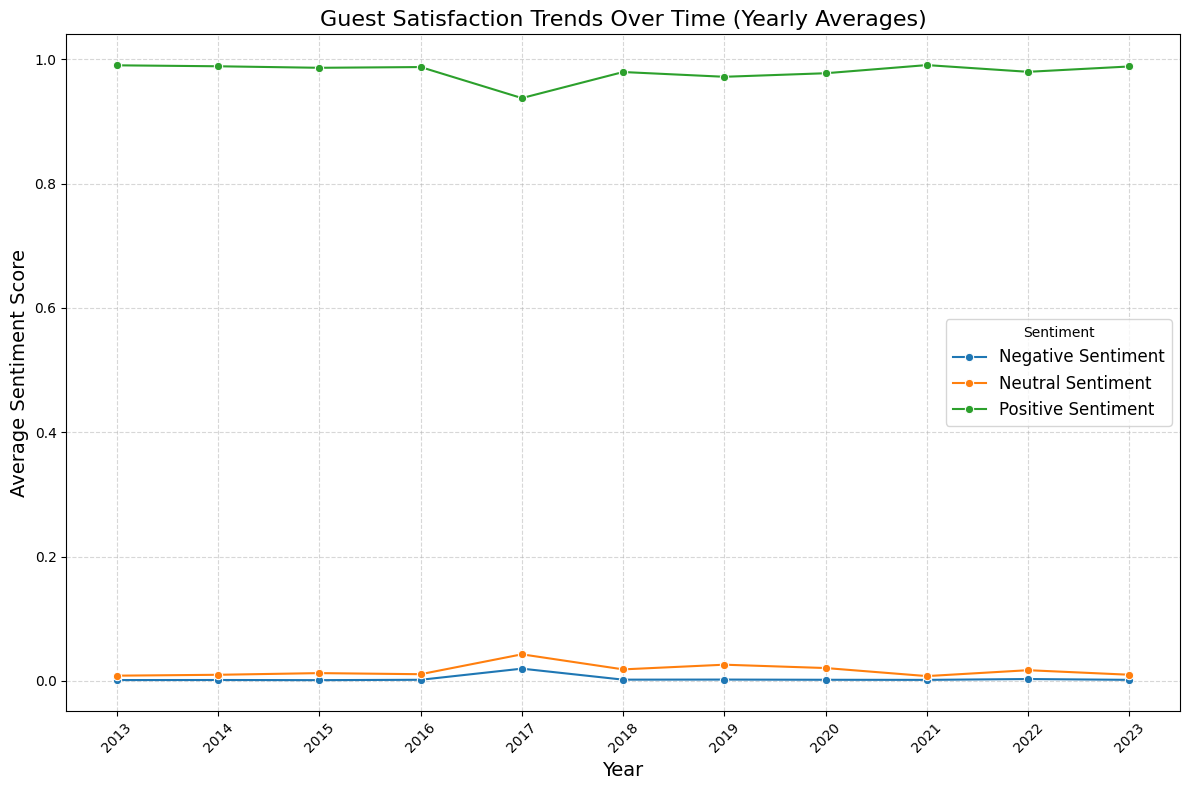

In [52]:
# Visualize guest satisfaction trends

# Convert 'date' column to datetime objects if it's not already
results_df['date'] = pd.to_datetime(results_df['date'])

# Group by year and calculate the mean sentiment scores
yearly_sentiment = results_df.groupby(results_df['date'].dt.year)[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Yearly Averages)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(yearly_sentiment.index, rotation=45)  # Show all years on x-axis and rotate for readability
plt.legend(title='Sentiment', fontsize=12) # Add legend title
plt.grid(True, linestyle='--', alpha=0.5) # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

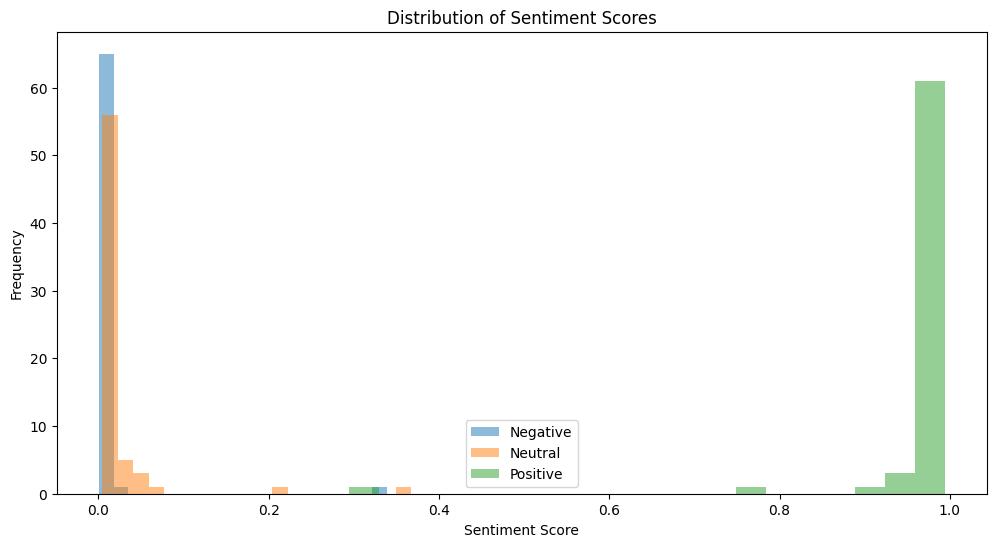

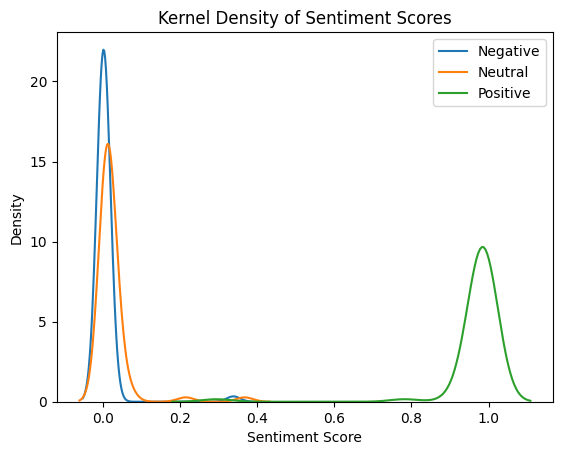

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'res' dictionary stores sentiment scores as:
# res = {review_id: {'roberta_neg': score, 'roberta_neu': score, 'roberta_pos': score}}

# Create a list of sentiment scores for each category
neg_scores = [d['roberta_neg'] for d in results.values()]
neu_scores = [d['roberta_neu'] for d in results.values()]
pos_scores = [d['roberta_pos'] for d in results.values()]

# Plotting histograms
plt.figure(figsize=(12, 6))
plt.hist(neg_scores, bins=20, alpha=0.5, label='Negative')
plt.hist(neu_scores, bins=20, alpha=0.5, label='Neutral')
plt.hist(pos_scores, bins=20, alpha=0.5, label='Positive')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Alternatively, using seaborn for kernel density plots
sns.kdeplot(neg_scores, label='Negative')
sns.kdeplot(neu_scores, label='Neutral')
sns.kdeplot(pos_scores, label='Positive')
plt.title('Kernel Density of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

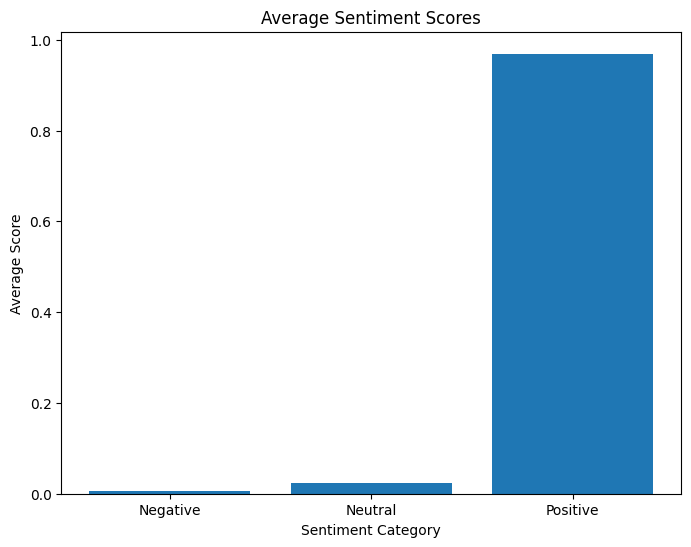

In [54]:
import numpy as np

# Calculate average sentiment scores
avg_neg = np.mean(neg_scores)
avg_neu = np.mean(neu_scores)
avg_pos = np.mean(pos_scores)

# Plotting bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Negative', 'Neutral', 'Positive'], [avg_neg, avg_neu, avg_pos])
plt.title('Average Sentiment Scores')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Score')
plt.show()

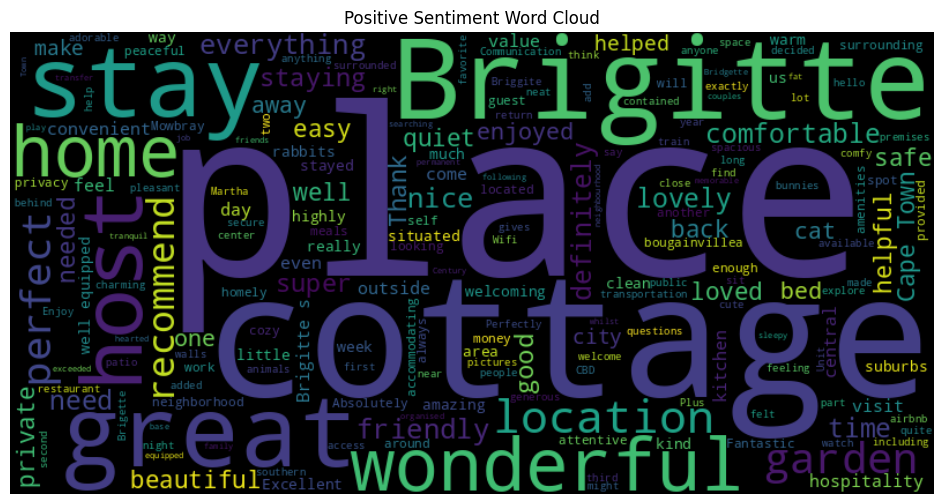

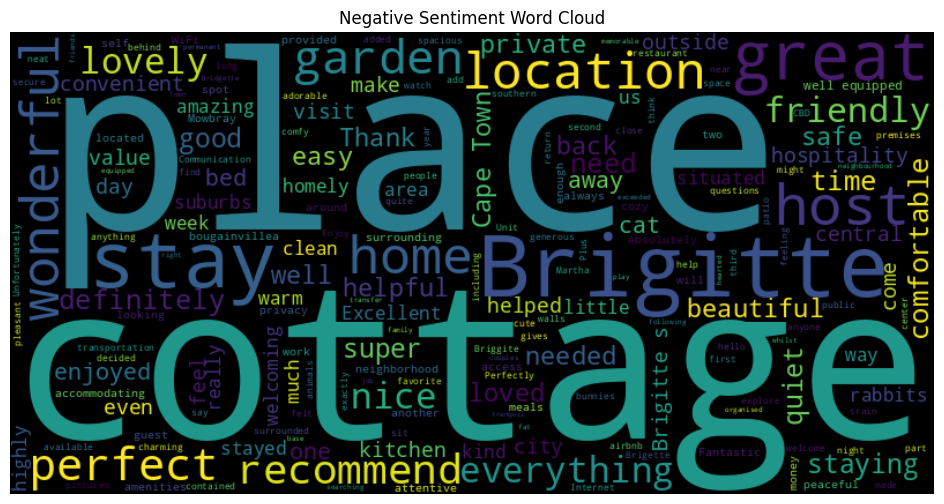

In [59]:
from wordcloud import WordCloud

# Assuming you have the original review text in a column called 'cleaned_comments' in your DataFrame
# and 'results_df' contains sentiment scores

# Create separate lists of reviews for each sentiment category
positive_reviews = results_df[results_df['roberta_pos'] > 0.5]['cleaned_comments'].tolist()
negative_reviews = results_df[results_df['roberta_neg'] < 0.5]['cleaned_comments'].tolist()

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400).generate(' '.join(positive_reviews))
negative_wordcloud = WordCloud(width=800, height=400).generate(' '.join(negative_reviews))

# Plot word clouds
plt.figure(figsize=(12, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()